In [1]:
import glob
import csv
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# !pip install funcy
import funcy
from funcy import print_durations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.cuda.amp import GradScaler
torch.backends.cudnn.benchmark = True
import datetime
import gc

/opt/conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
start_date = '1980-01-01'

In [3]:
returns_df = pd.read_csv('returns.csv',index_col=0).loc[start_date:]
# returns_df = returns_df.dropna(axis=0,thresh=500).dropna(axis=1,thresh=500)
equity_idx = returns_df.columns
date_idx = returns_df.index
returns_df

,0081A,0091A,0099A,0127A,0138A,0146A,0153A,0183B,0223B,0230B,...,ZVXI,ZWRK,ZWS,ZXAIY,ZY,ZYME,ZYNE,ZYXI,ZZ,ZZ1
datadate,,,,,,,,,,,,,,,,,,,,,
1980-01-31,NaN,0.012579,NaN,0.068182,0.039548,NaN,NaN,NaN,0.007752,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137500
1980-02-29,NaN,-0.006211,NaN,0.000000,NaN,NaN,NaN,NaN,-0.086462,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.164835
1980-03-31,NaN,-0.306250,NaN,0.007092,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.118421
1980-04-30,NaN,0.252252,NaN,-0.126761,NaN,NaN,NaN,NaN,0.139130,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.029851
1980-05-31,NaN,0.071942,NaN,0.177419,NaN,NaN,NaN,NaN,0.036336,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001025,-0.033076,0.001111,-0.145283,-0.096180,-0.096606,0.021548,NaN,NaN
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001026,0.038516,0.054384,-0.261589,-0.184983,-0.167630,-0.221094,NaN,NaN
2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.004620,-0.160989,0.084211,-0.222720,-0.456986,-0.093750,-0.115145,NaN,NaN


In [4]:
feat_comb_df = pd.read_csv('features_combined.csv').set_index(['tic','rdq']).drop(['FYEARQ','FQTR'],axis=1)
feat_comb_df = feat_comb_df[sorted(feat_comb_df.columns)]
feat_comb_df

A2ME  AC       ATO  BEME         C  CF  CF2P       CTO  \
tic   rdq                                                                      
0015B 1984-01-16  0.381941 NaN       NaN   NaN  0.214994 NaN   NaN       NaN   
      1984-03-15  0.557109 NaN       NaN   NaN  0.274170 NaN   NaN       NaN   
      1984-05-25  0.590922 NaN       NaN   NaN  0.140065 NaN   NaN       NaN   
      1984-08-27  0.651735 NaN       NaN   NaN  0.009504 NaN   NaN       NaN   
      1985-01-01  0.871765 NaN  0.760755   NaN  0.019574 NaN   NaN  0.778316   
...                    ...  ..       ...   ...       ...  ..   ...       ...   
ZZZ1  2000-08-14  1.171566 NaN  0.073420   NaN  0.036884 NaN   NaN  0.067789   
      2000-11-13  1.185838 NaN  0.079706   NaN  0.029840 NaN   NaN  0.069810   
      2001-03-28       NaN NaN  0.075438   NaN  0.041668 NaN   NaN  0.065717   
      2001-05-14       NaN NaN  0.085226   NaN  0.029079 NaN   NaN  0.082268   
      2001-08-13       NaN NaN  0.091314   NaN  0.040394 NaN   NaN  0.085981   

                       D2A       D2P  ...  OP       PCM        PM  PROF   Q  \
tic   rdq                             ...                                     
0015B 1984-01-16       NaN       NaN  ... NaN       NaN       NaN   NaN NaN   
      1984-03-15       NaN       NaN  ... NaN       NaN       NaN   NaN NaN   
      1984-05-25       NaN       NaN  ... NaN       NaN       NaN   NaN NaN   
      1984-08-27  0.015213  0.000000  ... NaN -0.968086  0.247569   NaN NaN   
      1985-01-01  0.012021  0.000000  ... NaN -0.950109  0.230870   NaN NaN   
...                    ...       ...  ...  ..       ...       ...   ...  ..   
ZZZ1  2000-08-14       NaN  0.006326  ... NaN  0.523240  1.000000   NaN NaN   
      2000-11-13       NaN  0.004737  ... NaN  0.559099  1.000000   NaN NaN   
      2001-03-28       NaN       NaN  ... NaN  0.540736  1.000000   NaN NaN   
      2001-05-14       NaN       NaN  ... NaN  0.622717  1.000000   NaN NaN   
      2001-08-13       NaN       NaN  ... NaN  0.653604  1.000000   NaN NaN   

                       RNA       ROA  ROE       S2P     SGA2S  
tic   rdq                                                      
0015B 1984-01-16       NaN       NaN  NaN       NaN       NaN  
      1984-03-15       NaN       NaN  NaN       NaN       NaN  
      1984-05-25       NaN       NaN  NaN       NaN       NaN  
      1984-08-27       NaN       NaN  NaN  1.418175  0.731681  
      1985-01-01  0.175636  0.125346  NaN  1.499765  0.748516  
...                    ...       ...  ...       ...       ...  
ZZZ1  2000-08-14  0.073420  0.018000  NaN  0.098857       NaN  
      2000-11-13  0.079706  0.021708  NaN  0.104211       NaN  
      2001-03-28  0.075438  0.021779  NaN       NaN       NaN  
      2001-05-14  0.085226  0.044324  NaN       NaN       NaN  
      2001-08-13  0.091314  0.062878  NaN       NaN       NaN  

[924199 rows x 29 columns]

In [5]:
MIN_AVAILABLE_FEATURES = 15

full_df_lst = []
for date in tqdm(date_idx):
    sub = feat_comb_df.loc[feat_comb_df.index.get_level_values(1) < date]
    sub = sub.groupby(sub.index.get_level_values('tic')).last(1)
    sub = sub.transpose()
    
    sub = sub.rank(pct=True,axis=1)*2-1
    idx = (sub.isna().sum(axis=0) >= MIN_AVAILABLE_FEATURES).index
    sub = sub[idx].fillna(0)
    
#     sub = sub.fillna(sub.median(axis=1),axis=0)
    
    sub['date'] = date
    sub =  sub.set_index(['date',sub.index])
    
    full_df_lst.append(sub)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [02:05<00:00,  4.03it/s]


In [6]:
del(feat_comb_df)
gc.collect()

0

In [ ]:
full_df_lst[0]

## Train test split

In [12]:
len(date_idx)

507

In [6]:
orig = (48,360)
valid = (360,420)
test = (420,505)
# Train: 1984 to 2010
# Valid: 2010 to 2015
# Test: 2015 to 2022

In [6]:
class AEDataSet(torch.utils.data.Dataset):
    def __init__(self, full_df_lst, returns_df, date_idx, start_i, end_i, rhs_input_assets=False,lag=1):
        self.full_df_lst = full_df_lst
        self.returns_df = returns_df
        self.date_idx = date_idx
        self.start_i, self.end_i = start_i, end_i
        self.rhs_input_assets = rhs_input_assets
        self.epsilon=1e-5
        self.lag=lag
        
        self.output_date_idx = date_idx[start_i+lag:end_i]
        
    def __len__(self):
        return self.end_i - self.start_i - self.lag
    def __getitem__(self, idx):
        input_idx = idx
        idx += self.start_i+self.lag
        date = self.date_idx[idx] # returns date
        
        mask = ~np.isnan(self.returns_df.loc[date].to_numpy())
        traded_assets_idx = self.returns_df.columns[mask]
        
        lhs = self.full_df_lst[idx - self.lag]
        lhs_idx = lhs.columns
        
        comb_idx = traded_assets_idx.intersection(lhs_idx)
        
        lhs = lhs.reindex(comb_idx,axis=1,fill_value=0).to_numpy()
        
        rhs_tmp = self.returns_df.loc[date,comb_idx]
        rhs_tmp = rhs_tmp.clip(rhs_tmp.quantile(0.01),rhs_tmp.quantile(0.99))
        output = rhs_tmp.to_numpy()

        lhs_tmp = np.concatenate([lhs,np.expand_dims(np.ones(lhs.shape[1]),0)],axis=0)
        
        
        if self.rhs_input_assets:
            rhs = output
        else:
            try:
#                 rhs = (np.linalg.inv(lhs @ lhs.T) @ lhs) @ rhs_tmp
                rhs = (np.linalg.inv(lhs_tmp @ lhs_tmp.T) @ lhs_tmp) @ rhs_tmp
#                 rhs = np.concatenate([rhs,[equal_weighted_portfolio]])
            except Exception as e:
                print("idx:",input_idx)
                print(e)
#                 return self.full_df_lst[idx - self.lag].reindex(traded_assets_idx,axis=1,fill_value=0), rhs_tmp
                # return lhs,lhs_tmp,output
                raise e
#             rhs.index = lhs_tmp.index
#             rhs = rhs.reindex(self.alpha_names,fill_value=0).clip(-5e4,5e4)
#             rhs['equal'] = equal_weighted_portfolio
#             rhs = rhs.to_numpy()
        return lhs,rhs,output,comb_idx
        
        
        

In [7]:
def collate_fn(batch):

    len_x = [len(output) for lhs,rhs,output,_ in batch]
    full_size = max(len_x)
#     print(full_size)
    
    batch_lhs = [nn.functional.pad(torch.Tensor(lhs),pad=(0,full_size-lhs.shape[1],0,0)) for lhs,rhs,output,_ in batch]
    batch_rhs = [torch.Tensor(rhs) for lhs,rhs,output,_ in batch]
    batch_output = [nn.functional.pad(torch.Tensor(output),pad=(0,full_size-len(output))) for lhs,rhs,output,_ in batch]
    batch_assets = [idx for lhs,rhs,output,idx in batch]
    
    return torch.cat([x.unsqueeze(0) for x in batch_lhs]),\
        torch.cat([x.unsqueeze(0) for x in batch_rhs]),\
        torch.cat([x.unsqueeze(0) for x in batch_output]), torch.tensor(len_x), batch_assets

#     # for i,(x,y) in enumerate(batch):
#     #   if i > 20:
#     #     break
#     #   print(torch.Tensor(x).shape, torch.Tensor(y).shape)

#     batch_x_pad = pad_sequence(batch_x)# TODO: pad the sequence with pad_sequence (already imported)
#     lengths_x = np.array([len(x) for x,y in batch]) # TODO: Get original lengths of the sequence before padding

#     batch_y_pad = pad_sequence(batch_y)# TODO: pad the sequence with pad_sequence (already imported)
#     lengths_y = np.array([len(y) for x,y in batch]) # TODO: Get original lengths of the sequence before padding

#     return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)

In [8]:
train_data = AEDataSet(full_df_lst,returns_df,date_idx,48,360)
valid_data = AEDataSet(full_df_lst,returns_df,date_idx,360,420)
test_data= AEDataSet(full_df_lst,returns_df,date_idx,420,505)

# del(full_df_lst)
gc.collect()

0

In [141]:
len_lst = []
for i in range(len(valid_data)):
    lhs,rhs,output,idx = valid_data[i]
    len_lst.append(lhs.shape[1])

In [142]:
print(lhs.shape, rhs.shape, output.shape,len(idx))

(29, 4851) (30,) (4851,) 4851


<AxesSubplot:>

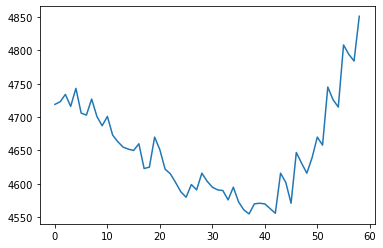

In [143]:
pd.Series(len_lst).plot()

In [150]:
train_loader = torch.utils.data.DataLoader(
    train,
    batch_size = 2,
    pin_memory=True,
    num_workers=1,
    shuffle=True,
    collate_fn = collate_fn
)

In [151]:
next(iter(train_loader))

[[tensor([[-0.8651,  0.4121,  0.0000,  ...,  0.0000, -0.7039, -0.4224],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.9516, -0.3789,  0.0000,  ...,  0.0000,  0.4629,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
  tensor([[ 0.3188,  0.0000,  0.7230,  ...,  0.0000,  0.0748,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.5303,  0.0000, -0.6134,  ...,  0.0000,  0.6962,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.3852,  0.0000,  0.4930,  ...,  0.0000,  0.7005,  0.0000],
          [-0.7829,  0.0000,  0.0000,  ...,  0.0000, -0.2299,  0.0000]])],
 [tensor([-0.0066,  0.0040,  0.0182,  0.0006,  0.0211, -0.0094,  0.0135, -0.0098,
           0.0009, 

## Conditional Autoencoder

In [137]:
# class ConditionalAutoEncoder(nn.Module):
#     def __init__(self,n_assets, n_alphas, n_factors, n_hidden_lhs, n_hidden_rhs, 
#                     batch_norm_lhs=True, batch_norm_rhs=False,
#                     dropout_p=0, initialization=True, rhs_input_assets = False,
#                     bn_momentum=0.1, bn_track_running_stats = True):
#         # n_assets can be assets or portfolios:
#             # In both cases, we are interested in asset return or portfolio return on the RHS
#             # LHS is the original factor 
#         super(ConditionalAutoEncoder, self).__init__()
        
#         # self.n_assets_alphas = n_assets * n_alphas
#         # self.n_assets_hidden = n_assets * n_hidden

#         self.n_assets = n_assets
#         self.n_alphas = n_alphas
#         self.n_factors = n_factors
#         self.n_hidden_lhs = n_hidden_lhs
#         self.n_hidden_rhs = n_hidden_rhs

#         self.lhs_lst = []

#         prev_lhs_layer_size = self.n_alphas
#         layer_lst = []
#         for v in n_hidden_lhs+[n_factors]:
#             if batch_norm_lhs:
#                 # layer_lst.append(nn.BatchNorm1d(prev_lhs_layer_size,momentum=bn_momentum,
#                 #         track_running_stats=bn_track_running_stats))
#                 layer_lst.append(nn.LayerNorm(prev_lhs_layer_size))
#             if dropout_p:
#                 layer_lst.append(nn.Dropout(dropout_p))
#             layer_lst.append(nn.Linear(prev_lhs_layer_size, v, bias=True))
#             if initialization:
#                 nn.init.kaiming_normal_(layer_lst[-1].weight,mode='fan_in',nonlinearity='linear')
#             layer_lst.append(nn.SELU())
#             prev_lhs_layer_size = v

#         # if batch_norm_lhs:
#         #     layer_lst.append(nn.BatchNorm1d(prev_lhs_layer_size,momentum=bn_momentum,
#         #             track_running_stats=bn_track_running_stats))
#         #     # layer_lst.append(nn.LayerNorm(prev_lhs_layer_size))
#         # if dropout_p:
#         #     layer_lst.append(nn.Dropout(dropout_p))
#         # layer_lst.append(nn.Linear(prev_lhs_layer_size, self.n_factors, bias=True))
#         # if initialization:
#         #     nn.init.xavier_normal_(layer_lst[-1].weight)
#         self.lhs = nn.Sequential(*layer_lst)

#         # self.lhs_lst = nn.ModuleList(self.lhs_lst)

#         rhs_lst = []
#         if rhs_input_assets:
#             if batch_norm_rhs:
#                 # rhs_lst.append(nn.BatchNorm1d(self.n_assets,momentum=bn_momentum,
#                 #     track_running_stats=bn_track_running_stats))
#                 rhs_lst.append(nn.LayerNorm(self.n_assets))
#             if dropout_p:
#                 rhs_lst.append(nn.Dropout(dropout_p))
#             rhs_lst.append(nn.Linear(n_assets,n_alphas,bias=True))
#             if initialization:
#                 nn.init.kaiming_normal_(rhs_lst[-1].weight,mode='fan_in',nonlinearity='linear')
#             # rhs_lst.append(nn.SELU())

#         prev_rhs_layer_size = self.n_alphas
#         for v in n_hidden_rhs+[n_factors]:
#             if batch_norm_rhs:
#               # rhs_lst.append(nn.BatchNorm1d(prev_rhs_layer_size,momentum=bn_momentum,
#               #         track_running_stats=bn_track_running_stats))
#                 rhs_lst.append(nn.LayerNorm(prev_rhs_layer_size))
#             if dropout_p:
#                 rhs_lst.append(nn.Dropout(dropout_p))
#             rhs_lst.append(nn.Linear(prev_rhs_layer_size,v,bias=True))
#             if initialization:
#                 nn.init.kaiming_normal_(rhs_lst[-1].weight,mode='fan_in',nonlinearity='linear')
#             rhs_lst.append(nn.SELU())
#             prev_rhs_layer_size = v
        
#         self.rhs = nn.Sequential(*rhs_lst)

#         self.final = nn.Linear(n_assets,n_assets,bias=True)

#     def forward(self, x_lhs, x_rhs):
#         # idx = 0
#         y_lhs_lst = []
#         for i in range(self.n_assets):
#             # y_cur = self.lhs_lst[i](x_lhs[:,idx:idx+self.n_alphas])
#             y_cur = self.lhs(x_lhs[:,:,i])
#             y_cur = torch.unsqueeze(y_cur,2)
#             y_lhs_lst.append(y_cur)
#             # idx += self.n_alphas
#         y_lhs = torch.cat(y_lhs_lst,dim=2)

#         y_rhs = self.rhs(x_rhs).unsqueeze(dim=2)
#         self.last_rhs_factors = y_rhs
#         # print("y_lhs, y_rhs: ", y_lhs.shape, y_rhs.shape)
#         # out = torch.tensordot(y_lhs,y_rhs,dims=([0,1],[0,1]))
#         # y_lhs, y_rhs:  torch.Size([568, 5, 1831]) torch.Size([568, 5])
#         out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
#         out = self.final(out)
#         return out

#     def forward_given_factors(self, x_lhs, factors):
#         y_lhs_lst = []
#         for i in range(self.n_assets):
#             # y_cur = self.lhs_lst[i](x_lhs[:,idx:idx+self.n_alphas])
#             y_cur = self.lhs(x_lhs[:,:,i])
#             y_cur = torch.unsqueeze(y_cur,2)
#             y_lhs_lst.append(y_cur)
#             # idx += self.n_alphas
#         y_lhs = torch.cat(y_lhs_lst,dim=2)

#         y_rhs = factors
#         out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
#         out = self.final(out)
#         return out

In [132]:
class ConditionalAutoEncoder(nn.Module):
    def __init__(self, n_alphas, n_factors, n_hidden_lhs, n_hidden_rhs, 
                    batch_norm_lhs=True, batch_norm_rhs=False,
                    dropout_p=0, initialization=True, rhs_input_assets = False,
                    bn_momentum=0.1, bn_track_running_stats = True):
        # n_assets can be assets or portfolios:
            # In both cases, we are interested in asset return or portfolio return on the RHS
            # LHS is the original factor 
        super(ConditionalAutoEncoder, self).__init__()
        
        # self.n_assets_alphas = n_assets * n_alphas
        # self.n_assets_hidden = n_assets * n_hidden

#         self.n_assets = n_assets
        self.n_alphas = n_alphas
        self.n_factors = n_factors
        self.n_hidden_lhs = n_hidden_lhs
        self.n_hidden_rhs = n_hidden_rhs

        self.lhs_lst = []

        prev_lhs_layer_size = self.n_alphas
        layer_lst = []
        for v in n_hidden_lhs+[n_factors]:
            if batch_norm_lhs:
                # layer_lst.append(nn.BatchNorm1d(prev_lhs_layer_size,momentum=bn_momentum,
                #         track_running_stats=bn_track_running_stats))
                layer_lst.append(nn.LayerNorm(prev_lhs_layer_size))
            if dropout_p:
                layer_lst.append(nn.Dropout(dropout_p))
            layer_lst.append(nn.Linear(prev_lhs_layer_size, v, bias=True))
            if initialization:
                nn.init.kaiming_normal_(layer_lst[-1].weight,mode='fan_in',nonlinearity='linear')
            layer_lst.append(nn.SELU())
            prev_lhs_layer_size = v

        # if batch_norm_lhs:
        #     layer_lst.append(nn.BatchNorm1d(prev_lhs_layer_size,momentum=bn_momentum,
        #             track_running_stats=bn_track_running_stats))
        #     # layer_lst.append(nn.LayerNorm(prev_lhs_layer_size))
        # if dropout_p:
        #     layer_lst.append(nn.Dropout(dropout_p))
        # layer_lst.append(nn.Linear(prev_lhs_layer_size, self.n_factors, bias=True))
        # if initialization:
        #     nn.init.xavier_normal_(layer_lst[-1].weight)
        self.lhs = nn.Sequential(*layer_lst)

        # self.lhs_lst = nn.ModuleList(self.lhs_lst)

        rhs_lst = []
        if rhs_input_assets:
            if batch_norm_rhs:
                # rhs_lst.append(nn.BatchNorm1d(self.n_assets,momentum=bn_momentum,
                #     track_running_stats=bn_track_running_stats))
                rhs_lst.append(nn.LayerNorm(self.n_assets))
            if dropout_p:
                rhs_lst.append(nn.Dropout(dropout_p))
            rhs_lst.append(nn.Linear(n_assets,n_alphas+1,bias=True))
            if initialization:
                nn.init.kaiming_normal_(rhs_lst[-1].weight,mode='fan_in',nonlinearity='linear')
            # rhs_lst.append(nn.SELU())

        prev_rhs_layer_size = self.n_alphas+1
        for v in n_hidden_rhs+[n_factors]:
            if batch_norm_rhs:
              # rhs_lst.append(nn.BatchNorm1d(prev_rhs_layer_size,momentum=bn_momentum,
              #         track_running_stats=bn_track_running_stats))
                rhs_lst.append(nn.LayerNorm(prev_rhs_layer_size))
            if dropout_p:
                rhs_lst.append(nn.Dropout(dropout_p))
            rhs_lst.append(nn.Linear(prev_rhs_layer_size,v,bias=True))
            if initialization:
                nn.init.kaiming_normal_(rhs_lst[-1].weight,mode='fan_in',nonlinearity='linear')
            rhs_lst.append(nn.SELU())
            prev_rhs_layer_size = v
        
        self.rhs = nn.Sequential(*rhs_lst)

#         self.final = nn.Linear(n_assets,n_assets,bias=True)

    def forward(self, x_lhs, x_rhs):
        # idx = 0
        y_lhs_lst = []
        for i in range(x_lhs.shape[2]):
            # y_cur = self.lhs_lst[i](x_lhs[:,idx:idx+self.n_alphas])
            y_cur = self.lhs(x_lhs[:,:,i])
            y_cur = torch.unsqueeze(y_cur,2)
            y_lhs_lst.append(y_cur)
            # idx += self.n_alphas
        y_lhs = torch.cat(y_lhs_lst,dim=2)

        y_rhs = self.rhs(x_rhs).unsqueeze(dim=2)
        self.last_rhs_factors = y_rhs
        out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
#         out = self.final(out)
        return out, y_rhs

    def forward_given_factors(self, x_lhs, factors):
        y_lhs_lst = []
        for i in range(x_lhs.shape[2]):
            # y_cur = self.lhs_lst[i](x_lhs[:,idx:idx+self.n_alphas])
            y_cur = self.lhs(x_lhs[:,:,i])
            y_cur = torch.unsqueeze(y_cur,2)
            y_lhs_lst.append(y_cur)
            # idx += self.n_alphas
        y_lhs = torch.cat(y_lhs_lst,dim=2)

        y_rhs = factors
        out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
#         out = self.final(out)
        return out

In [142]:
def forward_given_factors(self, x_lhs, factors):
    y_lhs_lst = []
    for i in range(x_lhs.shape[2]):
        # y_cur = self.lhs_lst[i](x_lhs[:,idx:idx+self.n_alphas])
        y_cur = self.lhs(x_lhs[:,:,i])
        y_cur = torch.unsqueeze(y_cur,2)
        y_lhs_lst.append(y_cur)
        # idx += self.n_alphas
#     print(len(y_lhs_lst))
    y_lhs = torch.cat(y_lhs_lst,dim=2)

    y_rhs = factors
    out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
#         out = self.final(out)
    return out

best_model.forward_given_factors = types.MethodType(forward_given_factors,best_model)

In [133]:
args = {
    'n_factors' : 5,
    # 'n_hidden' : 40,
    'n_hidden_lhs':[16,8],
    'n_hidden_rhs':[],
    'batch_norm_lhs' : True,
    'batch_norm_rhs' : False,
    'dropout_p' : 0.0,
    'max_norm' : 1,
    'bn_momentum': 0.01,
    'bn_track_running_stats': True,
    'initialization' : False,
    'rhs_input_assets' : False,
    'lr' : 5e-4,
    'gamma': 1/4,
    'l2_lambda': 0,
    'l1_lambda': 4e-3,
    'batch_size': 32,
    'log_interval': 1,
    'epoch': 20,
    'patience': 10
}

model = ConditionalAutoEncoder(
    n_alphas = 29,
    n_factors = args['n_factors'],
    n_hidden_lhs = args['n_hidden_lhs'],
    n_hidden_rhs = args['n_hidden_rhs'],
    batch_norm_lhs = args['batch_norm_lhs'],
    batch_norm_rhs = args['batch_norm_rhs'],
    dropout_p=args['dropout_p'],
    initialization=args['initialization'],
    rhs_input_assets=args['rhs_input_assets'],
#     bn_track_running_stats=args['bn_track_running_stats'],
#     bn_momentum=args['bn_momentum']
)

In [73]:
import gc
# del(train_loader)
gc.collect()
torch.cuda.empty_cache()

In [74]:


train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = 16,
    pin_memory=True,
    num_workers=1,
    shuffle=True,
    collate_fn = collate_fn
)



In [75]:
lhs,rhs,output,x_lens,idx = next(iter(train_loader))

In [ ]:
print(lhs.shape,rhs.shape,output.shape,x_lens.shape)

In [67]:
for lhs,rhs,output,x_lens in train_loader:
    print(lhs.shape,rhs.shape,output.shape,x_lens.shape)
    y = model(lhs,rhs,x_lens)
    print(y)
    break

torch.Size([16, 29, 8969]) torch.Size([16, 30]) torch.Size([16, 8969]) torch.Size([16])
tensor([[ 0.1571,  0.1633, -0.0507,  ...,  0.2846,  0.2488,  0.1280],
        [-0.1358,  0.2811, -0.2910,  ...,  0.3095,  0.2007,  0.2432],
        [ 8.4691, -8.4601, -4.0342,  ..., -8.0315, -6.1313, -5.1565],
        ...,
        [-0.2781,  0.2458,  0.1968,  ...,  0.2120,  0.3042,  0.1433],
        [ 0.0920,  0.3658, -0.0293,  ...,  0.3281,  0.1186,  0.2428],
        [ 0.0790,  0.2738,  0.2659,  ...,  0.2695,  0.1079,  0.1834]],
       grad_fn=<SqueezeBackward1>)


## Training

In [76]:


train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = 16,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
    collate_fn = collate_fn
)



valid_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size = 16,
    pin_memory=True,
    num_workers=0,
    shuffle=False,
    collate_fn = collate_fn
)



In [77]:
@print_durations()
def train(args, model, device, train_loader, optimizer, criterion, epoch, max_norm=None):
    model.train()
    # train_loader = torch.utils.data.DataLoader(
    #     train_data,
    #     batch_size = args['batch_size'],
    #     pin_memory=True,
    #     num_workers=4,
    #     shuffle=True
    # )
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 
    
    total_loss = 0
    total_reg_loss=0
    
    N = len(train_loader)
    
    for batch_idx, (data_lhs, data_rhs, data_output, data_x_lens, data_assets) in enumerate(train_loader):

        optimizer.zero_grad()
        
        data_lhs = data_lhs.float().to(device)
        data_rhs = data_rhs.float().to(device)
        data_output = data_output.float().to(device)
        data_x_lens = data_x_lens.int().to(device)

        if max_norm: torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        output,_ = model(x_lhs = data_lhs, x_rhs = data_rhs)
        
        data_mask = torch.arange(data_lhs.shape[2])[None, :].to(device) < data_x_lens[:, None]

        output_masked = torch.masked_select(output,data_mask)
        data_output_masked = torch.masked_select(data_output,data_mask)

        loss_tmp = criterion(output_masked, data_output_masked)

        regularization_loss = 0
        for p in model.parameters():
            regularization_loss += torch.sum(abs(p))

        loss = loss_tmp + args['l1_lambda'] * regularization_loss
#         print("Regularization Loss:", regularization_loss)
#         print("Batch Loss:", loss_tmp)
        loss.backward()
        total_loss += loss
        total_reg_loss += regularization_loss * args['l1_lambda'] 

        # print("Gradient:", loss.grad)
        optimizer.step()

#         if batch_idx % args['log_interval'] == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data_rhs), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))

        batch_bar.set_postfix(
            total_loss="{:.04f}".format(float(total_loss / (batch_idx + 1))),
            reg_loss = "{:.04f}".format(float(total_reg_loss / (batch_idx + 1))),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()
        
    print(f"Epoch {epoch}, total_loss={float(total_loss / N):.04f}, reg_loss = {float(total_reg_loss / N):.04f}")

In [78]:
from sklearn.metrics import mean_squared_error
@print_durations()
def test(args,model,device,test_loader,criterion):
    model.eval()
    # test_loader = torch.utils.data.DataLoader(
    #     dev_data,
    #     batch_size=args['batch_size'],
    #     pin_memory=False,
    #     num_workers=4,
    #     shuffle=False
    # )
        
    output_lst = []
    data_lst = []

    for data_lhs, data_rhs, data_output, data_x_lens, data_assets in test_loader:
        # print("Shapes:",data_lhs.shape, data_rhs.shape, data_output.shape, data_mask.shape)
        data_lhs = data_lhs.float().to(device)
        data_rhs = data_rhs.float().to(device)
        data_output = data_output.float().to(device)
        data_x_lens = data_x_lens.int().to(device)
        output,_ = model(x_lhs = data_lhs, x_rhs = data_rhs)

        data_mask = torch.arange(data_lhs.shape[2])[None, :].to(device) < data_x_lens[:, None]
        output_masked = torch.masked_select(output,data_mask)
        data_output_masked = torch.masked_select(data_output,data_mask)
        assert (len(output_masked) == torch.sum(data_x_lens))
        # print("Loss Inside:",criterion(output_masked,data_output_masked))

        output_lst.append(output_masked)
        data_lst.append(data_output_masked)
    
    full_output = torch.cat(output_lst,axis=0)
    full_data = torch.cat(data_lst,axis=0)

    # print("Loss:",criterion(full_output,full_data))

    # print(full_data.detach().numpy().shape)
    # print(full_output.detach().numpy().shape)

    return mean_squared_error(full_data.cpu().detach().numpy(), full_output.cpu().detach().numpy())

In [80]:
gc.collect()
torch.cuda.empty_cache()

model = ConditionalAutoEncoder(
    n_alphas = 29,
    n_factors = args['n_factors'],
    n_hidden_lhs = args['n_hidden_lhs'],
    n_hidden_rhs = args['n_hidden_rhs'],
    batch_norm_lhs = args['batch_norm_lhs'],
    batch_norm_rhs = args['batch_norm_rhs'],
    dropout_p=args['dropout_p'],
    initialization=args['initialization'],
    rhs_input_assets=args['rhs_input_assets'],
#     bn_track_running_stats=args['bn_track_running_stats'],
#     bn_momentum=args['bn_momentum']
)

# model=best_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=args['lr'], weight_decay=args['l2_lambda'])
criterion = torch.nn.MSELoss()

train_mse = test(args,model,device,train_loader,criterion)
valid_mse = test(args,model,device,valid_loader,criterion)
train_mse_lst, valid_mse_lst = [train_mse], [valid_mse]

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=args['gamma'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',0.5,patience=5,threshold=1e-3,cooldown=10)
print("Pre-Train Train MSE:", train_mse)
print("Pre-Train Valid MSE:", valid_mse)

best_model = None
for epoch in range(1, args['epoch']+1):
    log_dict = {}

    gc.collect()
    torch.cuda.empty_cache()
    
    train(args,model,device,train_loader,optimizer,criterion,epoch,max_norm=args['max_norm'])
    gc.collect()
    torch.cuda.empty_cache()

    log_dict['train_mse'] = test(args,model,device,train_loader,criterion)
    log_dict['valid_mse'] = test(args,model,device,valid_loader,criterion)
    log_dict['lr'] = scheduler.optimizer.state_dict()['param_groups'][0]['lr']
    
    gc.collect()
    torch.cuda.empty_cache()

    print("Train MSE:",log_dict['train_mse'])
    print("Valid MSE:",log_dict['valid_mse'])

    scheduler.step(log_dict['valid_mse'])
    print('Next Learning Rate:', scheduler.optimizer.state_dict()['param_groups'][0]['lr'])

    print(train_mse_lst)
    print(valid_mse_lst)
    if log_dict['valid_mse'] < np.min(valid_mse_lst):
        best_model = model
        torch.save(best_model, './best_model.model')
        # torch.save(model.state_dict(), args['MODEL_PATH']+"/model_epoch_"+str(epoch))

    train_mse_lst.append(log_dict['train_mse'])
    valid_mse_lst.append(log_dict['valid_mse'])

    if len(valid_mse_lst)>args['patience'] and log_dict['valid_mse'] > \
        np.min(valid_mse_lst[:-args['patience']]):
            break

Epoch 1, total_loss=0.6076, reg_loss = 0.4855
   93.02 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 1, max_norm=1)
   41.14 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.90 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.12177345
Valid MSE: 0.016363947
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0.0351231, 0.030073753, 0.02648949, 0.023810526, 0.021941718, 0.020596847, 0.019747028, 0.019045793, 0.018430535, 0.017904073, 0.017420717, 0.017016

Epoch 2, total_loss=0.6049, reg_loss = 0.4838
   94.35 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 2, max_norm=1)
   41.07 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.86 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.11633989
Valid MSE: 0.016109686
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0.0351231, 0.030073753, 0.02648949, 0.023810526, 0.021941718, 0.020596847, 0.019747028, 0.019045793, 0.018430535, 0.017904073, 0.0174207

Epoch 3, total_loss=0.6096, reg_loss = 0.4822
   91.42 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 3, max_norm=1)
   41.18 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.86 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.11210884
Valid MSE: 0.015887432
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0.0351231, 0.030073753, 0.02648949, 0.023810526, 0.021941718, 0.020596847, 0.019747028, 0.019045793, 0.018430535, 0.01790407

Epoch 4, total_loss=0.5891, reg_loss = 0.4806
   93.02 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 4, max_norm=1)
   40.83 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.87 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.1073154
Valid MSE: 0.015707124
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0.0351231, 0.030073753, 0.02648949, 0.023810526, 0.021941718, 0.020596847, 0.019747028, 0.019045793, 0.018430535,

Epoch 5, total_loss=0.5845, reg_loss = 0.4791
   92.63 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 5, max_norm=1)
   41.32 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.93 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.10353146
Valid MSE: 0.015557777
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0.0351231, 0.030073753, 0.02648949, 0.023810526, 0.021941718, 0.020596847, 0.019747028, 0.019045793, 

Epoch 6, total_loss=0.5783, reg_loss = 0.4776
   92.86 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 6, max_norm=1)
   41.25 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.90 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.10031202
Valid MSE: 0.015436189
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0.0351231, 0.030073753, 0.02648949, 0.023810526, 0.021941718, 0.020596847, 0.019747028, 0

Epoch 7, total_loss=0.5739, reg_loss = 0.4760
   92.00 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 7, max_norm=1)
   41.26 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.93 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.09720949
Valid MSE: 0.015332695
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0.0351231, 0.030073753, 0.02648949, 0.023810526, 0.021941718, 0.020596847, 0.

Epoch 8, total_loss=0.5684, reg_loss = 0.4745
   92.50 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 8, max_norm=1)
   40.70 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.85 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.09456702
Valid MSE: 0.015253238
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0.0351231, 0.030073753, 0.02648949, 0.023810526, 0.021941718, 0.0

Epoch 9, total_loss=0.5722, reg_loss = 0.4731
   93.11 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 9, max_norm=1)
   41.24 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.92 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.091893405
Valid MSE: 0.015175137
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949, 0.09456702]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0.0351231, 0.030073753, 0.02648949, 0.023810526, 0.0

Epoch 10, total_loss=0.5615, reg_loss = 0.4717
   92.34 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 10, max_norm=1)
   40.93 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.86 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.089081585
Valid MSE: 0.015113552
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949, 0.09456702, 0.091893405]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0.0351231, 0.030073753, 0.02648949, 0

Epoch 11, total_loss=0.5599, reg_loss = 0.4703
   92.51 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 11, max_norm=1)
   41.14 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.86 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.08681241
Valid MSE: 0.015060264
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949, 0.09456702, 0.091893405, 0.089081585]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0.0351231, 0.030073753, 0

Epoch 12, total_loss=0.5534, reg_loss = 0.4690
   93.24 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 12, max_norm=1)
   41.20 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.86 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.08473553
Valid MSE: 0.015017773
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949, 0.09456702, 0.091893405, 0.089081585, 0.08681241]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0.0351231, 0.

Epoch 13, total_loss=0.5514, reg_loss = 0.4676
   93.23 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 13, max_norm=1)
   41.41 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.85 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.08291259
Valid MSE: 0.014983303
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949, 0.09456702, 0.091893405, 0.089081585, 0.08681241, 0.08473553]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137, 0.04151002, 0

Epoch 14, total_loss=0.5482, reg_loss = 0.4663
   92.84 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 14, max_norm=1)
   41.93 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.92 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.081066325
Valid MSE: 0.0149508575
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949, 0.09456702, 0.091893405, 0.089081585, 0.08681241, 0.08473553, 0.08291259]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 0.04892137,

Epoch 15, total_loss=0.5450, reg_loss = 0.4649
   93.30 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 15, max_norm=1)
   40.96 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.84 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.07945688
Valid MSE: 0.014919368
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949, 0.09456702, 0.091893405, 0.089081585, 0.08681241, 0.08473553, 0.08291259, 0.081066325]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304, 0.05770639, 

Epoch 16, total_loss=0.5461, reg_loss = 0.4635
   93.10 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 16, max_norm=1)
   41.00 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.84 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.078055285
Valid MSE: 0.014896113
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949, 0.09456702, 0.091893405, 0.089081585, 0.08681241, 0.08473553, 0.08291259, 0.081066325, 0.07945688]
[0.075177625, 0.08522023, 0.08598911, 0.07671226, 0.06649304,

Epoch 17, total_loss=0.5476, reg_loss = 0.4622
   92.93 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 17, max_norm=1)
   41.10 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.89 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.07642325
Valid MSE: 0.014870508
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949, 0.09456702, 0.091893405, 0.089081585, 0.08681241, 0.08473553, 0.08291259, 0.081066325, 0.07945688, 0.078055285]
[0.075177625, 0.08522023, 0.08598911, 0.07671226,

Epoch 18, total_loss=0.5370, reg_loss = 0.4608
   92.89 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 18, max_norm=1)
   41.62 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.93 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.07488224
Valid MSE: 0.014850898
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949, 0.09456702, 0.091893405, 0.089081585, 0.08681241, 0.08473553, 0.08291259, 0.081066325, 0.07945688, 0.078055285, 0.07642325]
[0.075177625, 0.08522023, 0.08598911,

Epoch 19, total_loss=0.5328, reg_loss = 0.4594
   93.66 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 19, max_norm=1)
   41.39 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.87 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.07350586
Valid MSE: 0.014833291
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949, 0.09456702, 0.091893405, 0.089081585, 0.08681241, 0.08473553, 0.08291259, 0.081066325, 0.07945688, 0.078055285, 0.07642325, 0.07488224]
[0.075177625, 0.08522023,

Epoch 20, total_loss=0.5329, reg_loss = 0.4580
   93.01 s in train({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., AdamW ( Parameter Grou..., MSELoss(), 20, max_norm=1)
   41.19 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
    5.85 s in test({'n_factors': 5, 'n_hi..., ConditionalAutoEncoder..., cuda, <torch.utils.data.data..., MSELoss())
Train MSE: 0.072417244
Valid MSE: 0.014817381
Next Learning Rate: 0.0005
[17.50345, 7.5426044, 3.59657, 1.8628666, 1.0087838, 0.61535084, 0.45654303, 0.36876833, 0.31906736, 0.28359097, 0.2519579, 0.22906509, 0.20959683, 0.19282946, 0.17995153, 0.1679116, 0.15750854, 0.1492778, 0.13989426, 0.13360532, 0.12708151, 0.12177345, 0.11633989, 0.11210884, 0.1073154, 0.10353146, 0.10031202, 0.09720949, 0.09456702, 0.091893405, 0.089081585, 0.08681241, 0.08473553, 0.08291259, 0.081066325, 0.07945688, 0.078055285, 0.07642325, 0.07488224, 0.07350586]
[0.075177625

## Evaluation

In [81]:
# train_loader = torch.utils.data.DataLoader(
#     train_data,
#     batch_size = 16,
#     pin_memory=True,
#     num_workers=0,
#     shuffle=False,
#     collate_fn = collate_fn
# )

n_window=36

# cur_data = test_data

# test_loader = torch.utils.data.DataLoader(
#     cur_data,
#     batch_size = 16,
#     pin_memory=True,
#     num_workers=0,
#     shuffle=False,
#     collate_fn = collate_fn
# )

extended_valid_data = AEDataSet(full_df_lst,returns_df,date_idx,360-n_window,420)
extended_test_loader = torch.utils.data.DataLoader(
    extended_valid_data,
    batch_size = 16,
    pin_memory=True,
    num_workers=0,
    shuffle=False,
    collate_fn = collate_fn
)

test_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size = 16,
    pin_memory=True,
    num_workers=0,
    shuffle=False,
    collate_fn = collate_fn
)


In [83]:
factors.shape

torch.Size([16, 5, 1])

In [85]:
output_lst = []
data_lst = []
factors_lst = []

for data_lhs, data_rhs, data_output, data_x_lens, data_assets in tqdm(extended_test_loader):
    # print("Shapes:",data_lhs.shape, data_rhs.shape, data_output.shape, data_mask.shape)
    data_lhs = data_lhs.float().to(device)
    data_rhs = data_rhs.float().to(device)
    data_output = data_output.float().to(device)
    data_x_lens = data_x_lens.int().to(device)
    output, factors = best_model(x_lhs = data_lhs, x_rhs = data_rhs)

    data_mask = torch.arange(data_lhs.shape[2])[None, :].to(device) < data_x_lens[:, None]
    output_masked = torch.masked_select(output,data_mask)
    data_output_masked = torch.masked_select(data_output,data_mask)
    assert (len(output_masked) == torch.sum(data_x_lens))
    # print("Loss Inside:",criterion(output_masked,data_output_masked))
    
    indices = [0]+list(torch.cumsum(data_x_lens,axis=0).cpu().numpy())
    
    for k,(i,j) in enumerate(zip(indices[:-1],indices[1:])):
        output_lst.append(pd.Series(output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
        data_lst.append(pd.Series(data_output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
        factors_lst.append(pd.Series(factors[k].squeeze().cpu().detach().numpy()))
    
    
    
# full_output = torch.cat(output_lst,axis=0)
# full_data = torch.cat(data_lst,axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.77s/it]


In [86]:
output_df = pd.DataFrame(output_lst,index=extended_valid_data.output_date_idx).iloc[n_window:]
data_output_df = pd.DataFrame(data_lst,index=extended_valid_data.output_date_idx).iloc[n_window:]
factors_df = pd.DataFrame(factors_lst,index = extended_valid_data.output_date_idx)

0.019874809151589623


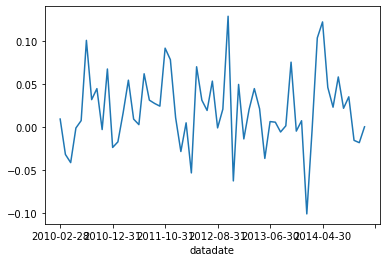

In [89]:
corr = output_df.corrwith(returns_df.loc[output_df.index,output_df.columns],axis=1,method='spearman')
# corr = output_df.corrwith(data_output_df.loc[output_df.index,output_df.columns],axis=1,method='spearman')
corr.plot()
print(corr.mean())

Predicted Return Metrics

In [165]:
# factors = factors.squeeze().cpu().detach().numpy()

# factors = pd.DataFrame(factors,index = cur_data.dates).sort_index()
predicted_factors = factors_df.rolling(n_window).mean()

factors_tensor = torch.tensor(predicted_factors.iloc[n_window:].to_numpy()).unsqueeze(2).float().to(device)
factors_tensor.shape

torch.Size([59, 5, 1])

In [166]:
batch_size = 16

output_lst = []
for i, (data_lhs, _, _, data_x_lens, data_assets) in tqdm(enumerate(test_loader),total=len(test_loader)):
    # print("Shapes:",data_lhs.shape, data_rhs.shape, data_output.shape, data_mask.shape)
    data_lhs = data_lhs.float().to(device)
    data_x_lens = data_x_lens.int().to(device)
    output= best_model.forward_given_factors(x_lhs = data_lhs, factors = factors_tensor[i*batch_size:(i+1)*batch_size])

    data_mask = torch.arange(data_lhs.shape[2])[None, :].to(device) < data_x_lens[:, None]
    output_masked = torch.masked_select(output,data_mask)
#     print(data_lhs.shape,factors_tensor[i*batch_size:(i+1)*batch_size].shape,data_output.shape,data_mask.shape)
#     data_output_masked = torch.masked_select(data_output,data_mask)
    assert (len(output_masked) == torch.sum(data_x_lens))
    # print("Loss Inside:",criterion(output_masked,data_output_masked))
    
    indices = [0]+list(torch.cumsum(data_x_lens,axis=0).cpu().numpy())
    
    for k,(i,j) in enumerate(zip(indices[:-1],indices[1:])):
        output_lst.append(pd.Series(output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
#         data_lst.append(pd.Series(data_output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
#         factors_lst.append(pd.Series(factors[i].cpu().detach().numpy()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/it]


In [167]:
tm1_predicted_returns = pd.DataFrame(output_lst,index=predicted_factors.iloc[n_window:].index)
predicted_returns = tm1_predicted_returns.shift(1).iloc[1:]
predicted_returns

,3GLOI.,7131B,A,AA.3,AABA,AACC,AACG,AAI,AAIC,AAME,...,VEC,VIA,VRTV,VTAE,VTTI,WGBS,WLKP,WMS,XENT,YUMA.1
datadate,,,,,,,,,,,,,,,,,,,,,
2010-03-31,-0.008440,0.014590,0.009826,0.004267,-0.002452,0.008887,-0.001435,0.012925,-0.006155,0.014182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-30,-0.007795,0.014694,0.010139,0.004043,-0.002286,0.009270,0.000916,0.013123,0.001041,0.014564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-31,-0.007178,0.014759,0.010281,0.003946,-0.002150,-0.013246,0.001035,0.013291,0.001474,0.017263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-30,-0.007266,0.005520,0.009985,0.006621,0.003808,-0.011477,0.000565,0.012831,0.001024,0.015450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-31,-0.008604,0.005213,0.009843,0.006663,0.003315,-0.011801,0.000213,0.012417,0.009505,0.015122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-31,-0.008298,0.004990,0.010103,0.006606,0.003643,-0.011188,0.002255,0.012845,0.009878,0.015682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-30,-0.008382,0.022004,0.010152,0.007415,0.002769,-0.012047,0.002082,0.031276,0.009061,0.015920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-31,-0.009137,0.022454,0.008986,0.007335,0.003079,-0.011560,0.003740,0.031717,0.009391,0.013913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-30,-0.009002,0.022485,0.009078,0.007325,0.003200,-0.011372,0.003804,0.031893,0.009518,0.014074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Predictive Stats

0.015717689213086583


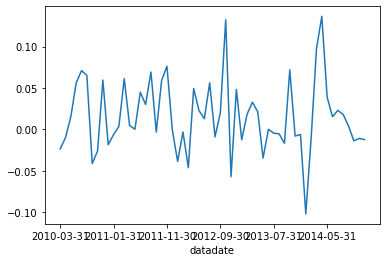

In [204]:
corr = predicted_returns.corrwith(returns_df.loc[predicted_returns.index,predicted_returns.columns],axis=1,method='spearman')
# corr = output_df.corrwith(data_output_df.loc[output_df.index,output_df.columns],axis=1,method='spearman')
corr.plot()
print(corr.mean())

-0.001537611120698704


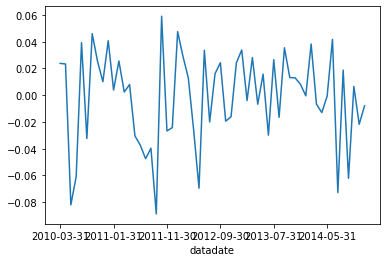

In [201]:
numer = (returns_df.loc[predicted_returns.index,predicted_returns.columns]-predicted_returns)
numer_mask = (~numer.isna()).astype(int)

denom = returns_df.loc[predicted_returns.index,predicted_returns.columns] * numer_mask

pred_r2_ser = 1 - ((numer**2).sum(axis=1))/(denom**2).sum(axis=1)
pred_r2_ser.plot()
# pred_corr.rolling(60).mean().plot(secondary_y=True)
print(pred_r2_ser.mean())

Attribution Stats

0.019874809151589623


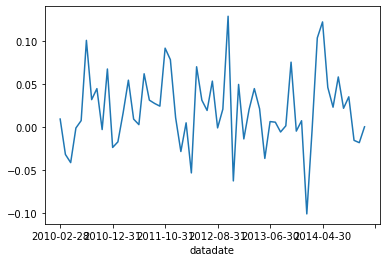

In [174]:
corr = output_df.corrwith(returns_df.loc[output_df.index,output_df.columns],axis=1,method='spearman')
# corr = output_df.corrwith(data_output_df.loc[output_df.index,output_df.columns],axis=1,method='spearman')
corr.plot()
print(corr.mean())

0.03798778902167721

0.017240526586913094


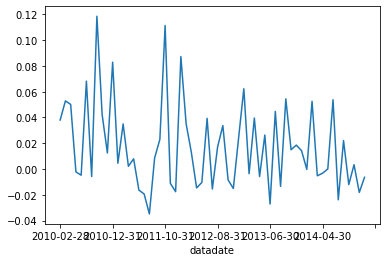

In [199]:
numer = (returns_df.loc[output_df.index,output_df.columns]-output_df)
numer_mask = (~numer.isna()).astype(int)

denom = returns_df.loc[output_df.index,output_df.columns] * numer_mask


r2_ser = 1 - ((numer**2).sum(axis=1))/(denom**2).sum(axis=1)

r2_ser.plot()
# corr.rolling(60).mean().plot(secondary_y=True)
print(r2_ser.mean())

Trading Sharpe

In [177]:
train_pred_rank = predicted_returns.rank(pct=True,axis=1,numeric_only=True,ascending=True)

Annualized Return: 0.1338659990900888
Annualized SD: 0.15815426588111406
Annualized Sharpe: 0.8464267362267487


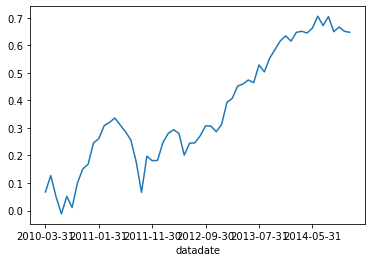

In [190]:
long_port = ((train_pred_rank >= 0.9) & (train_pred_rank < 1)).astype(int)
long_port = long_port.divide(long_port.sum(axis=1),axis=0)
long_port_returns = (long_port*returns_df.loc[long_port.index]).sum(axis=1)
long_port_returns.cumsum().plot()
print("Annualized Return:",long_port_returns.mean()*12)
print("Annualized SD:",long_port_returns.std()*np.sqrt(12))
print("Annualized Sharpe:",(long_port_returns.mean()/long_port_returns.std())*np.sqrt(12))

Annualized Return: 0.1534679977273342
Annualized SD: 0.1766361617668915
Annualized Sharpe: 0.868836800982278


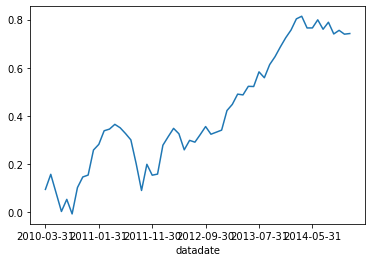

In [191]:
# train_pred_rank = train_pred.rank(pct=True,axis=1,numeric_only=True,ascending=False)
short_port = (train_pred_rank <= 0.1).astype(int)
short_port = short_port.divide(short_port.sum(axis=1),axis=0)
short_port_returns = (short_port*returns_df.loc[short_port.index]).sum(axis=1)
short_port_returns.cumsum().plot()
print("Annualized Return:",short_port_returns.mean()*12)
print("Annualized SD:",short_port_returns.std()*np.sqrt(12))
print("Annualized Sharpe:",(short_port_returns.mean()/short_port_returns.std())*np.sqrt(12))


Annualized Return: -0.01960199863724541
Annualized SD: 0.06019979009358344
Annualized Sharpe: -0.3256157306657244


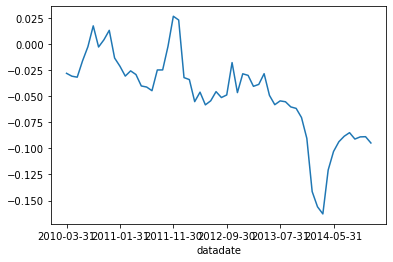

In [192]:
comb_port_returns = ((long_port - short_port)*returns_df.loc[short_port.index]).sum(axis=1)
comb_port_returns.cumsum().plot()
print("Annualized Return:",comb_port_returns.mean()*12)
print("Annualized SD:",comb_port_returns.std()*np.sqrt(12))
print("Annualized Sharpe:",(comb_port_returns.mean()/comb_port_returns.std())*np.sqrt(12))